# VapeCops: 실시간 흡연 감지 시스템 🚭

**작성자**: 정원주  
**최종 업데이트**: 2024년 11월 21일  
**GitHub**: [VapeCops 프로젝트 저장소](https://github.com/username/vapecops)

---

## 소개

VapeCops 프로젝트는 딥러닝 기반의 실시간 흡연 감지 시스템으로, 공공장소에서의 비흡연 환경을 조성하기 위해 개발되었습니다. 이 노트북에서는 Jupyter Notebook 환경에서 TensorFlow와 OpenCV를 활용하여 MobileNet 모델을 학습시키는 과정을 보여줍니다. 학습된 모델은 다양한 형식으로 변환되어 Raspberry Pi와 같은 엣지 디바이스에 배포되며, 흡연 행위를 감지하면 경고음을 울리는 이동식 로봇 플랫폼에 통합됩니다.

이 프로젝트를 통해 MobileNet 모델을 학습하고, TFLite 형식으로 변환하여 Raspberry Pi와 같은 엣지 디바이스에서 실시간 감지 시스템을 구축하는 방법을 배울 수 있습니다.


## Working in Jupyter Notebook

이 프로젝트는 Jupyter Notebook 환경에서 진행되었으며, Python과 다양한 딥러닝 라이브러리(TensorFlow, OpenCV 등)를 사용하여 실시간 흡연 감지 모델을 학습시킵니다. Jupyter Notebook은 직관적인 코드 실행 및 시각화 기능을 제공하여 데이터 전처리, 모델 학습 및 평가 과정을 효과적으로 관리할 수 있도록 합니다.

> **Note**: Python 3.11 환경을 권장하며, 가상환경을 설정하여 필요한 패키지들을 설치하는 것을 추천합니다. 

이 Jupyter Notebook은 MobileNet을 사용하여 학습을 진행하였으며, 학습 완료 후 모델을 다양한 형식으로 변환하여 Raspberry Pi에 배포할 수 있습니다.

### 1. 학습 이미지 수집 및 라벨링

모델 학습을 위해 먼저 학습에 사용할 이미지 데이터셋을 준비해야 합니다. 이 프로젝트에서는 사용자가 Kaggle에서 다운로드 받거나, 직접 수집한 데이터셋을 활용하여 학습을 진행합니다. 

학습 이미지는 다양한 배경과 조명 조건에서 흡연 및 비흡연 상태를 잘 표현할 수 있도록 구성해야 합니다. 각 이미지에는 적절한 라벨링이 필요하며, `smoking`과 `notsmoking` 두 가지 클래스를 포함해야 합니다.

#### 데이터셋 구조 예시

데이터셋은 아래와 같은 폴더 구조를 따라야 합니다:

In [ ]:
dataset/
├── train/
│   ├── smoking/
│   │   ├── image1.jpg
│   │   └── image2.jpg
│   └── notsmoking/
│       ├── image1.jpg
│       └── image2.jpg
├── validation/
│   ├── smoking/
│   │   └── image1.jpg
│   └── notsmoking/
│       └── image1.jpg
└── test/
    ├── smoking/
    │   └── image1.jpg
    └── notsmoking/
        └── image1.jpg


## 데이터셋 압축 해제 및 자동 삭제

이 코드는 `dataset.zip` 파일이 현재 디렉토리에 있는 경우, 이를 자동으로 `dataset/` 폴더에 압축 해제하고, 압축 해제 후 `dataset.zip` 파일을 삭제하는 코드 입니다. 데이터셋을 효율적으로 관리하고, 불필요한 파일을 제거하여 저장 공간을 절약할 수 있습니다.

> **Note**: 이 스크립트는 `dataset.zip` 파일이 Jupyter Notebook과 같은 디렉토리에 있다고 가정합니다.

In [1]:
from zipfile import ZipFile
import os

# dataset.zip 파일이 같은 폴더에 있다고 가정하고 압축 해제
zip_filename = 'dataset.zip'

# 압축 파일이 존재하는지 확인하고 압축 해제
if os.path.exists(zip_filename):
    with ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('dataset')
    print(f"Extracted: {zip_filename} to 'dataset/' folder")
else:
    print(f"Error: {zip_filename} 파일을 찾을 수 없습니다.")

# 압축 파일 삭제
if os.path.exists(zip_filename):
    os.remove(zip_filename)
    print(f"Deleted: {zip_filename}")
else:
    print(f"Error: {zip_filename} 파일을 삭제할 수 없습니다.")


Extracted: dataset.zip to 'dataset/' folder
Deleted: dataset.zip


In [1]:
import os
# 현재 디렉토리의 dataset 폴더로 이동
os.chdir('dataset')
print("Current Directory:", os.getcwd())

Current Directory: D:\VapeCops\dataset


## 이미지 데이터 전처리하기

이 코드는 `ImageDataGenerator`를 사용하여 이미지 데이터셋을 배치 단위로 생성하는 코드입니다. 이미지 데이터는 픽셀 값을 0~1 사이로 정규화하여 학습에 적합한 형태로 변환됩니다. `generate_data` 함수는 설정된 `target_size`(기본값 124x124), `batch_size`(기본값 32), `class_mode`(기본값 'categorical') 및 `color_mode`를 통해 다양한 이미지 데이터셋을 쉽게 로드할 수 있도록 합니다.

> **Note**: `training_set_directory` 변수는 실제 훈련 데이터가 저장된 경로로 설정해야 합니다.

```python

#### 1. 훈련 이미지 데이터 전처리하기

In [7]:
#필요한 라이브러리 다운로드
!pip install tensorflow==2.8
!pip install Pillow
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

  Using cached tensorflow-2.8.0-cp39-cp39-win_amd64.whl.metadata (2.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.12.1-cp39-cp39-win_amd64.whl.metadata (2.5 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.28.3-cp39-cp39-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached wrapt-1.16.0-cp39-cp39-win_amd64.whl.metadata (6.8 kB)
  

In [3]:
!pip install protobuf==3.20.*
!pip install "numpy<2"

  Using cached protobuf-3.20.3-cp39-cp39-win_amd64.whl.metadata (699 bytes)
Using cached protobuf-3.20.3-cp39-cp39-win_amd64.whl (904 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator 생성: 이미지 픽셀값을 0~1 사이로 정규화합니다.
train_datagen = ImageDataGenerator(rescale=1.0/255)

# 사용자 정의 데이터 생성기 함수
def generate_data(generator, directory, target_size=(124, 124), batch_size=32, class_mode='categorical', color_mode='rgb'):
    data_gen = generator.flow_from_directory(
        directory=directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        color_mode=color_mode,
        shuffle=True  # 훈련 이미지 순서를 무작위로 섞음
    )
    while True:
        # 배치를 생성하여 반환
        yield next(data_gen)

# 경로를 실제 훈련 데이터 폴더 경로로 설정
training_set_directory = 'train'  # 이미지 훈련 데이터가 있는 폴더 경로

# 사용자 정의 생성기를 사용하여 데이터 로드
training_set = generate_data(
    train_datagen,
    directory=training_set_directory,
    target_size=(124, 124),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

# 데이터 배치 테스트 (첫 번째 배치만 확인)
batch = next(training_set)
print("배치 로드 성공:", batch[0].shape, batch[1].shape)


Found 15612 images belonging to 2 classes.
배치 로드 성공: (32, 124, 124, 3) (32, 2)


#### 2. 테스트 이미지 데이터 전처리하기

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 테스트 데이터셋을 위한 ImageDataGenerator 생성
test_datagen = ImageDataGenerator(rescale=1.0/255)

# 테스트 데이터셋 생성
test_set = test_datagen.flow_from_directory(
    'test',                  # 테스트 데이터가 있는 폴더명 
    target_size=(124, 124),    # 이미지 크기
    shuffle=False,           # 테스트 데이터는 순서를 섞지 않음
    class_mode='categorical' # 다중 클래스 레이블을 원-핫 인코딩 형태로 반환
)

# 검증 데이터셋을 위한 ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1.0/255)

# 검증 세트 생성
validation_generator = train_datagen.flow_from_directory(
    'validation',            # 검증 데이터 디렉토리
    target_size=(124, 124),    # 모든 이미지를 75x75로 조정
    batch_size=32,
    class_mode='categorical'
)

Found 926 images belonging to 2 classes.
Found 6687 images belonging to 2 classes.


## MobileNet 모델 생성 및 레이어 동결

이 코드는 사전 학습된 MobileNet 모델을 불러와 새로운 학습에 사용할 준비를 하는 과정입니다.

1. **MobileNet 모델 생성**  
   - `MobileNet` 클래스를 사용하여 ImageNet 데이터셋으로 사전 학습된 MobileNet 모델을 로드합니다.
   - `include_top=False`: 최종 분류 레이어를 제외하고 가져옵니다.
   - `weights='imagenet'`: ImageNet 데이터셋으로 학습된 가중치를 사용합니다.
   - `input_shape=(75, 75, 3)`: 입력 이미지 크기를 (75, 75)로 지정하여 해당 크기의 RGB 이미지를 처리할 수 있도록 설정합니다.

2. **모델 요약 출력**  
   - `vgg.summary()`를 통해 모델의 레이어 구성과 파라미터 수를 확인합니다. MobileNet의 구조를 이해하고 모델의 크기와 복잡도를 파악하는 데 유용합니다.

3. **레이어 동결**  
   - `for` 루프를 사용하여 모델의 모든 레이어를 **동결(freeze)** 처리하여, 학습 중 가중치가 업데이트되지 않도록 설정합니다.
   - 이렇게 하면 MobileNet의 사전 학습된 특성 추출 기능을 유지하면서, 최종 분류 레이어만 학습할 수 있어 학습 시간을 절약하고 기존 가중치를 효과적으로 활용할 수 있습니다.

이 과정은 Transfer Learning(전이 학습)을 위한 준비 단계로, MobileNet의 특성 추출 능력을 활용하여 새로운 데이터셋에 맞게 추가 학습할 수 있게 합니다.

#### 3. 훈련 이미지 데이터 특징 추출하기

In [5]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

# MobileNet 모델 불러오기 (변수명을 vgg로 설정)
vgg = MobileNet(include_top=False, input_shape=(124, 124, 3))

# 레이어를 동결하여 학습되지 않도록 설정
for layer in vgg.layers:
    layer.trainable = False

# 새 모델 정의
model = Sequential()
model.add(Input(shape=(124, 124, 3)))        # 모델 입력 정의
model.add(vgg)                             # MobileNet 모델 추가 (변수명 vgg)
#model.add(GlobalAveragePooling2D())        # Flatten 대신 사용
model.add(Flatten())
model.add(Dense(64, activation='relu'))    # 은닉층 추가
model.add(Dense(2, activation='softmax'))  # 출력층 추가

# 모델 구조 요약 출력
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                589888    
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3,818,882
Trainable params: 590,018
Non-trainable params: 3,228,864
_________________________________________________________________


#### 4. 분류 모델 환경 설정하기

In [6]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## ModelCheckpoint를 사용한 모델 가중치 저장 및 학습 설정

이 코드는 **모델 학습 과정에서 매 에포크마다 가중치를 저장**하기 위해 `ModelCheckpoint` 콜백을 사용하는 방법을 보여줍니다. 이를 통해 각 에포크에서 학습된 가중치를 별도의 파일로 저장하여, 이후 특정 에포크의 가중치를 불러와 학습을 재개하거나 모델을 평가할 수 있습니다.

### 1. ModelCheckpoint 콜백 생성
`ModelCheckpoint` 콜백을 설정하여 매 에포크마다 모델의 가중치를 자동으로 저장합니다.

- `filepath='model_epoch_{epoch:02d}.h5'`: 파일 이름에 에포크 번호가 포함되도록 설정하여, 예를 들어 `model_epoch_01.h5`, `model_epoch_02.h5`와 같은 형식으로 저장됩니다.
- `save_freq='epoch'`: 매 에포크가 종료될 때마다 가중치를 저장합니다.
- `save_weights_only=True`: 모델의 가중치만 저장하며, 모델의 구조는 저장하지 않습니다. (구조까지 저장하려면 `False`로 설정)

### 2. 모델 학습 설정
`model.fit()` 함수에서 학습을 시작하며, `ModelCheckpoint` 콜백을 사용하여 가중치를 자동 저장하도록 설정합니다.

- `training_set`: 학습에 사용할 데이터셋
- `epochs=12`: 총 12 에포크 동안 학습
- `steps_per_epoch=steps_per_epoch`: 각 에포크에서 실행할 스텝(배치) 수
- `callbacks=[checkpoint]`: 매 에포크마다 `ModelCheckpoint` 콜백을 사용하여 가중치를 저장

이 설정을 통해 학습 과정에서 각 에포크마다 모델 가중치를 저장할 수 있으며, 저장된 가중치를 통해 특정 시점의 모델을 재사용하거나 평가할 수 있습니다.

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# ModelCheckpoint 설정: 마지막 모델 저장
checkpoint = ModelCheckpoint(
    'model.h5',                # 저장할 파일 이름
    monitor='val_accuracy',         # 검증 정확도를 모니터링
    save_best_only=False,           # 매 epoch마다 저장 (동일 파일에 덮어쓰기)
    save_weights_only=False,        # 전체 모델 저장
    verbose=1                       # 저장 시 메시지 출력
)

# steps_per_epoch 자동 계산
steps_per_epoch = len(training_set)

# 모델 학습
history = model.fit(
    training_set,
    epochs=8,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,  # 검증 데이터를 추가하여 모니터링 가능하게 함
    callbacks=[checkpoint]                 # 체크포인트 콜백 추가
)

# 저장된 모델 로드
model = load_model('model.h5')  # 마지막 저장된 모델 로드


TypeError: object of type 'generator' has no len()

#### 4. Saved model directory 형식으로 파일 저장

In [ ]:
# SavedModel 형식으로 저장
model.save('saved_model_directory', save_format='tf')

#### 4. h5 형식으로 파일 저장

In [ ]:
# 모델 저장 (h5 형식)
model.save('smoking_classifier.h5')

## 모델 학습 정확도(Accuracy)와 손실(Loss) 그래프 시각화

이 코드는 `matplotlib` 라이브러리를 사용하여 **모델 학습 과정**에서의 **정확도(accuracy)**와 **손실(loss)** 변화를 에포크(epoch) 단위로 시각화합니다.  
**훈련 데이터**와 **검증 데이터**에 대해 각각 시각화하여 모델 학습 성능을 평가하는 데 유용합니다.

---

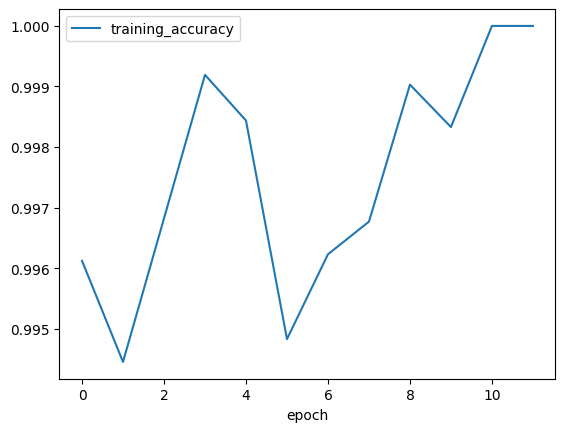

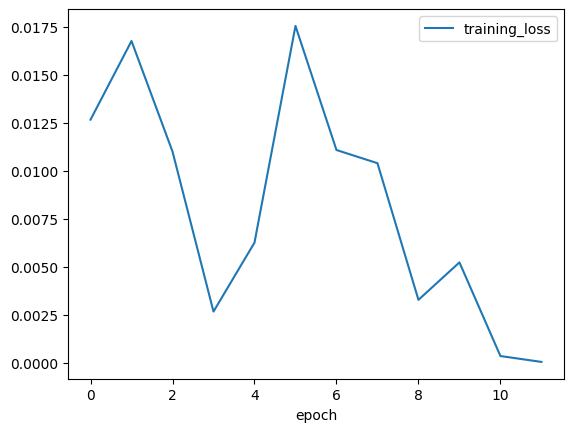

In [45]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')  # 검증 정확도 추가
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')  # 검증 손실 추가
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


## 합성곱 신경망 모델 평가 및 예측

이 코드는 학습된 모델을 테스트 세트에 대해 평가하고, 예측을 수행하는 과정을 보여줍니다.

### 4.1 모델 평가
- **`model.evaluate(test_set)`**: 테스트 세트를 사용해 모델의 **손실(loss)**과 **정확도(accuracy)**를 평가합니다.
  - 출력 예시: `loss: 1.0962 - accuracy: 0.9136` (약 91%의 정확도)

### 4.2 예측하기

1. **클래스 인덱스 확인**
   - **`test_set.class_indices`**: 클래스와 인덱스 간의 매핑을 확인합니다.  
     예: `{'notsmoking': 0, 'smoking': 1}`

2. **모델 예측 생성**
   - **`model.predict(test_set)`**: 테스트 세트에 대한 예측 확률을 생성합니다.
   - 각 샘플에 대해 클래스별 확률을 배열로 출력합니다.

3. **예측 결과 클래스 추출**
   - **`np.argmax(predictions, axis=1)`**: 각 샘플의 예측 확률 중 가장 높은 값을 가진 클래스 인덱스를 추출하여 최종 예측 클래스를 얻습니다.

#### 4. 모델 평가하기

In [7]:
model.evaluate(test_set)

NameError: name 'model' is not defined

#### 5. 예측하기

In [35]:
test_set.class_indices

{'notsmoking': 0, 'smoking': 1}

In [36]:
predictions = model.predict(test_set)
predictions

29/29 [==============================] - 13s 439ms/step


array([[9.9999964e-01, 3.3671782e-07],
       [1.0000000e+00, 9.6643374e-18],
       [9.9974853e-01, 2.5152735e-04],
       ...,
       [4.5220367e-19, 1.0000000e+00],
       [3.8002684e-11, 1.0000000e+00],
       [9.9206334e-01, 7.9366127e-03]], dtype=float32)

In [37]:
import numpy as np
print(np.argmax(predictions, axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 

## 모델 예측 결과 혼동 행렬 시각화

이 코드는 테스트 데이터에 대한 모델의 예측 결과와 실제 레이블을 비교하여 **혼동 행렬(confusion matrix)**을 생성하고 시각화하는 과정입니다. 혼동 행렬은 모델의 분류 성능을 평가하는 데 유용한 도구입니다.

### 코드 요약

1. **예측 생성**
   - `model.predict(test_set)`: 테스트 데이터셋에 대해 예측을 수행합니다.
   - `np.argmax(predictions, axis=1)`: 예측 확률 중 가장 높은 값을 가진 클래스 인덱스를 추출하여 최종 예측 클래스를 얻습니다.

2. **실제 레이블 가져오기**
   - `test_set.classes`: 테스트 데이터셋의 실제 레이블을 가져옵니다.

3. **혼동 행렬 계산 및 시각화**
   - `confusion_matrix(truth, prediction)`: 실제 레이블과 예측 레이블을 비교하여 혼동 행렬을 계산합니다.
   - `sns.heatmap(...)`: Seaborn 라이브러리를 사용해 혼동 행렬을 시각화하여, 각 클래스에 대한 올바른 예측과 오류를 한눈에 볼 수 있도록 합니다.

이 과정을 통해 모델이 테스트 데이터에서 각 클래스를 얼마나 잘 예측하는지 시각적으로 확인할 수 있습니다.


29/29 [==============================] - 13s 437ms/step


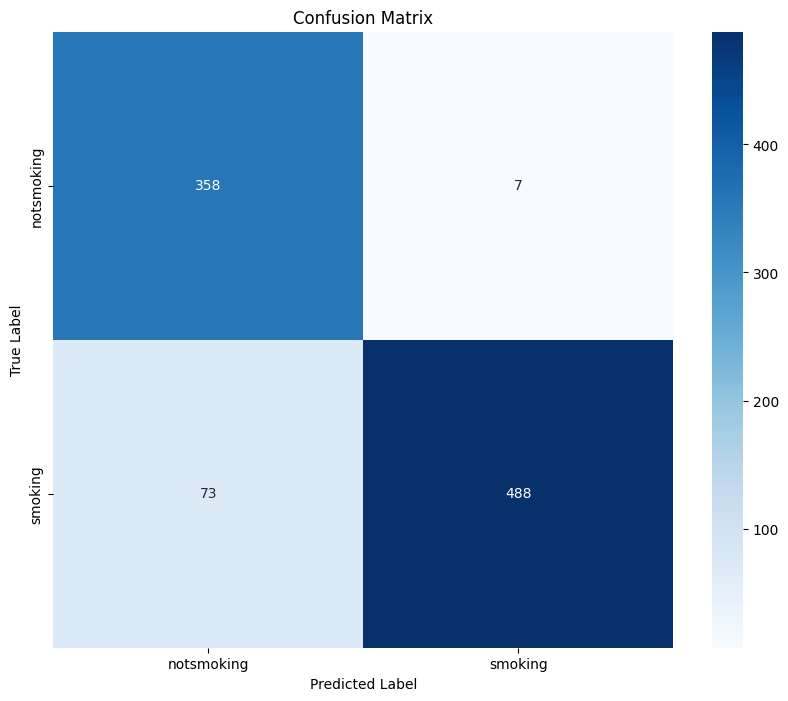

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 테스트 데이터에 대한 예측 생성
predictions = model.predict(test_set)  # 모델이 test_set에 대해 예측 수행

# 예측 결과에서 가장 높은 확률을 가진 클래스의 인덱스를 추출
prediction = np.argmax(predictions, axis=1)

# 테스트 데이터의 실제 레이블을 가져옴
truth = test_set.classes  # test_set.labels로도 사용할 수 있음

# 혼동 행렬 계산
conf_matrix = confusion_matrix(truth, prediction)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## 모델 분류 성능 평가: Precision, Recall, F1-score, Accuracy

이 코드는 **모델의 예측 결과와 실제 레이블을 비교**하여 분류 성능 지표(Precision, Recall, F1-score, Accuracy)를 계산하고 출력합니다. 이를 통해 모델이 각 클래스에 대해 얼마나 잘 예측하는지 평가할 수 있습니다.

### 코드 설명

1. **예측 생성 및 실제 레이블 준비**
   - `model.predict(test_set)`: 테스트 데이터셋에 대한 예측을 생성합니다.
   - `np.argmax(predictions, axis=1)`: 예측 확률 중 가장 높은 값을 가진 클래스 인덱스를 추출합니다.
   - `truth = test_set.classes`: 테스트 데이터셋의 실제 레이블을 가져옵니다.

2. **분류 성능 지표 출력**
   - `classification_report(...)`: **Precision(정밀도)**, **Recall(재현율)**, **F1-score**, **Support**(각 클래스의 샘플 수)를 포함한 분류 성능 보고서를 출력합니다.
   - `target_names=test_set.class_indices.keys()`: 클래스 이름을 지정하여 출력 시 클래스 이름이 표시되도록 합니다.

3. **정확도(Accuracy) 계산 및 출력**
   - `accuracy_score(truth, prediction)`: 전체 정확도를 계산하여 출력합니다.

이 과정을 통해 모델의 분류 성능을 종합적으로 평가할 수 있으며, 각 클래스별 성능과 전체 정확도를 확인할 수 있습니다.


In [43]:
from sklearn.metrics import classification_report, accuracy_score

# 예측 결과와 실제 레이블
predictions = model.predict(test_set)
prediction = np.argmax(predictions, axis=1)
truth = test_set.classes

# Precision, Recall, F1-score, Accuracy 계산 및 출력
print("Classification Report:")
print(classification_report(truth, prediction, target_names=test_set.class_indices.keys()))

# Accuracy 계산
accuracy = accuracy_score(truth, prediction)
print(f"\nAccuracy: {accuracy:.4f}")


29/29 [==============================] - 13s 440ms/step
Classification Report:
              precision    recall  f1-score   support

  notsmoking       0.83      0.98      0.90       365
     smoking       0.99      0.87      0.92       561

    accuracy                           0.91       926
   macro avg       0.91      0.93      0.91       926
weighted avg       0.92      0.91      0.91       926


Accuracy: 0.9136


## 모델 분류 성능 종합 평가

In [42]:
from sklearn.metrics import classification_report, accuracy_score

# 예측 결과와 실제 레이블
predictions = model.predict(test_set)
prediction = np.argmax(predictions, axis=1)
truth = test_set.classes

# Classification Report 계산
report = classification_report(truth, prediction, target_names=test_set.class_indices.keys(), output_dict=True)

# Accuracy 계산
accuracy = accuracy_score(truth, prediction)

# 전체 지표 출력
print("Model Performance Summary:")
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")
print(f"Accuracy: {accuracy:.4f}")


29/29 [==============================] - 13s 442ms/step
Model Performance Summary:
Precision: 0.9247
Recall: 0.9136
F1-score: 0.9145
Accuracy: 0.9136


## 성능 평가 결과의 다양한 시각화

이 프로젝트에서는 모델의 성능을 평가하기 위해 다양한 방법으로 결과를 시각화했습니다. 이를 통해 모델이 각 클래스에 대해 얼마나 잘 예측하는지, 그리고 전반적인 분류 성능이 어떤지 쉽게 파악할 수 있습니다.

### 사용된 시각화 방법
1. **정확도 및 손실 그래프**: 학습 과정 중 에포크에 따른 정확도와 손실의 변화를 그래프로 시각화하여 모델의 수렴 정도와 학습 상태를 확인했습니다.
2. **혼동 행렬(Confusion Matrix)**: 모델의 예측 결과와 실제 레이블을 비교하여 혼동 행렬을 생성하고 시각화함으로써 클래스별 예측 정확도를 한눈에 볼 수 있도록 했습니다.
3. **분류 성능 지표(Precision, Recall, F1-score)**: Precision, Recall, F1-score와 같은 분류 성능 지표를 계산하고, 이를 통해 모델이 각 클래스에 대해 얼마나 잘 예측하는지 상세히 분석했습니다.

이러한 시각화 방법들은 모델의 성능을 종합적으로 평가하고, 성능 향상을 위한 인사이트를 얻는 데 도움이 됩니다.

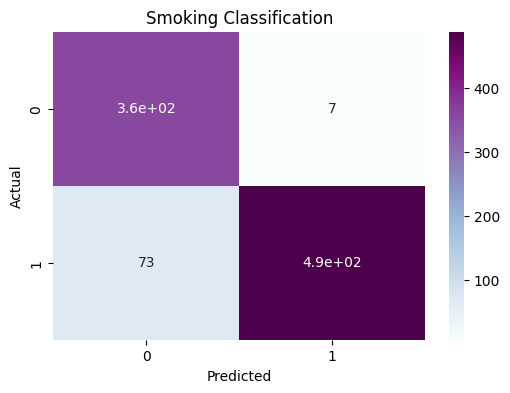

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix  # 혼동행렬 함수를 불러옴

# 예측결과에서 가장 큰 값의 인덱스를 추출함
prediction = np.argmax(predictions, axis=1)
truth =  test_set.labels   # 테스트 데이터의 실제 레이블을 가져옴

# 혼동행렬을 계산함 (실제값, 예측값)
conf = confusion_matrix(truth, prediction)

# 혼동행렬을 표시함
plt.figure(figsize=(6, 4))  # 그림 크기 설정함
sns.heatmap(conf, annot=True, cmap="BuPu")

# 제목, x축 이름(Prediction), y축 이름(Truth)을 설정함
plt.title("Smoking Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Keras 모델을 TensorFlow Lite(TFLite) 형식으로 변환 (Optional)

이 코드는 **Keras에서 저장된 .h5 모델을 TensorFlow Lite(TFLite) 형식으로 변환**하여, 모바일 및 임베디드 환경에서 사용할 수 있도록 준비합니다.

### 코드 요약
1. **모델 로드**  
   - `final_model.keras` 파일에서 Keras 모델을 불러옵니다.

2. **TFLite 변환**  
   - TFLiteConverter를 사용해 모델을 TFLite 형식으로 변환하며, 최적화를 적용하여 모델 크기와 성능을 개선합니다.

3. **변환된 모델 저장**  
   - `smoking_classifier.tflite` 파일로 저장하여 TFLite 모델을 사용 가능하게 합니다.

In [47]:
import tensorflow as tf
from tensorflow import keras

# .h5 모델 로드
model = tf.keras.models.load_model("smoking_classifier.keras")

# TFLite 변환기 설정 및 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# 변환된 모델 저장
with open("smoking_classifier.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\gdchung\AppData\Local\Temp\tmplfiz8vp2\assets


INFO:tensorflow:Assets written to: C:\Users\gdchung\AppData\Local\Temp\tmplfiz8vp2\assets


## Keras 모델을 8비트 정수 양자화하여 TFLite 형식으로 변환 (Optional)

이 코드는 **Keras에서 저장된 모델을 8비트 정수 양자화하여 Edge TPU와 호환되는 TensorFlow Lite(TFLite) 형식으로 변환**하는 과정입니다.

### 코드 요약
1. **대표 데이터셋 생성**  
   - 양자화에 사용할 대표 데이터셋을 생성하여, 변환 과정에서 모델의 정밀도를 유지합니다.

2. **모델 로드 및 변환기 설정**  
   - Keras 모델을 불러와 TFLite 변환기에서 8비트 정수 양자화를 적용하도록 설정합니다.
   - Edge TPU 호환성을 위해 입력 및 출력 데이터 타입을 `int8`로 지정합니다.

3. **양자화된 모델 저장**  
   - 변환된 TFLite 모델을 `smoking_classifier_quantized.tflite` 파일로 저장하여 Edge TPU 환경에서 사용할 수 있도록 준비합니다.


In [48]:
import tensorflow as tf
import numpy as np

# 대표 데이터셋 함수 정의 (양자화에 사용할 샘플 데이터를 제공합니다)
def representative_data_gen():
    for _ in range(100):  # 예제 100개
        # 75x75 이미지 크기로 임의 데이터 생성 (또는 실제 데이터로 교체)
        dummy_input = np.random.rand(1, 75, 75, 3) * 255
        dummy_input = dummy_input.astype(np.float32)
        yield [dummy_input]

# 기존 모델 로드
model = tf.keras.models.load_model("smoking_classifier.keras")

# TFLite 변환기 설정
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Edge TPU 호환을 위해 8비트 정수 양자화 설정
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# 입력과 출력 데이터 타입을 int8로 지정
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# 대표 데이터셋 설정
converter.representative_dataset = representative_data_gen

# 양자화된 모델로 변환
tflite_model = converter.convert()

# 양자화된 모델 저장
with open("smoking_classifier_quantized.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\gdchung\AppData\Local\Temp\tmp4uu4etst\assets


INFO:tensorflow:Assets written to: C:\Users\gdchung\AppData\Local\Temp\tmp4uu4etst\assets
C:\Users\gdchung\.conda\envs\myenv\lib\site-packages\tensorflow\lite\python\convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
